In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U tensorflow-gpu=="2.0"

Requirement already up-to-date: tensorflow-gpu==2.0 in /usr/local/lib/python3.6/dist-packages (2.0.0)


In [3]:
!pip install pycocotools

In [4]:
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3375, done.
remote: Counting objects: 100% (3375/3375), done.
remote: Compressing objects: 100% (2861/2861), done.
remote: Total 3375 (delta 659), reused 2048 (delta 436), pack-reused 0
Receiving objects: 100% (3375/3375), 371.06 MiB | 37.19 MiB/s, done.
Resolving deltas: 100% (659/659), done.
Checking out files: 100% (3189/3189), done.


In [0]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [6]:
%%bash 
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1017523 sha256=c3f565cebb33a1139c656428dc831a6e7eedf40075f7bc02611453b8f373732e
  Stored in directory: /tmp/pip-ephem-wheel-cache-w0xrcl8e/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection


In [0]:
!cp '/content/drive/My Drive/CEO_Foundry_LLC/achbogga_exporter.py' '/content/models/research/object_detection/exporter.py'

In [0]:
!PYTHONPATH=$PYTHONPATH:models/research/slim python "drive/My Drive/CEO_Foundry_LLC/save_deployable_model.py" --model_configuration "/content/drive/My Drive/CEO_Foundry_LLC/training/ssd_inception_v2_medical_images.config" \
    --model_dir_path "/content/drive/My Drive/CEO_Foundry_LLC/training" \
    --output_dir_path "/content/drive/My Drive/CEO_Foundry_LLC/inference/medical_images_deployable"

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

In [0]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [0]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

In [0]:
def load_model(model_dir_path):
  model = tf.compat.v2.saved_model.load(str(model_dir_path), None)
  model = model.signatures['serving_default']

  return model

In [0]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'drive/My Drive/CEO_Foundry_LLC/medical_images_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [0]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('/content/drive/My Drive/CEO_Foundry_LLC/Total')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.png")))
TEST_IMAGE_PATHS

In [0]:
model_dir_path = '/content/drive/My Drive/CEO_Foundry_LLC/inference/medical_images_deployable/saved_model'
detection_model = load_model(model_dir_path)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(?, ?, ?, 3) dtype=uint8>]


In [0]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_multiclass_scores': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32,
 'raw_detection_boxes': tf.float32,
 'raw_detection_scores': tf.float32}

In [0]:
detection_model.output_shapes

{'detection_boxes': TensorShape([Dimension(None), Dimension(40), Dimension(4)]),
 'detection_classes': TensorShape([Dimension(None), Dimension(40)]),
 'detection_multiclass_scores': TensorShape([Dimension(None), Dimension(40), Dimension(20)]),
 'detection_scores': TensorShape([Dimension(None), Dimension(40)]),
 'num_detections': TensorShape([Dimension(None)]),
 'raw_detection_boxes': TensorShape([Dimension(None), Dimension(None), Dimension(4)]),
 'raw_detection_scores': TensorShape([Dimension(None), Dimension(None), Dimension(20)])}

In [0]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  print ('num_detections: ', num_detections)
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [0]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  if len(image_np.shape)==2:
    image_np = np.array(Image.open(image_path).convert('RGB'))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

In [0]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
masking_model = load_model("mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28")

727392256/727390102 [==============================] - 8s 0us/step
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
masking_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_masks': TensorShape([None, None, None, None]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

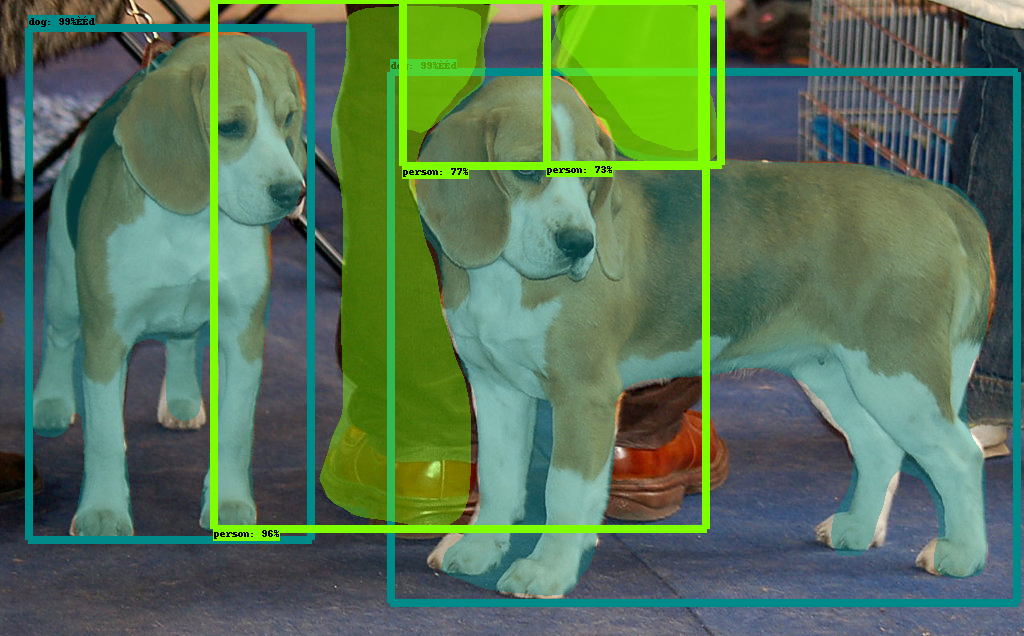

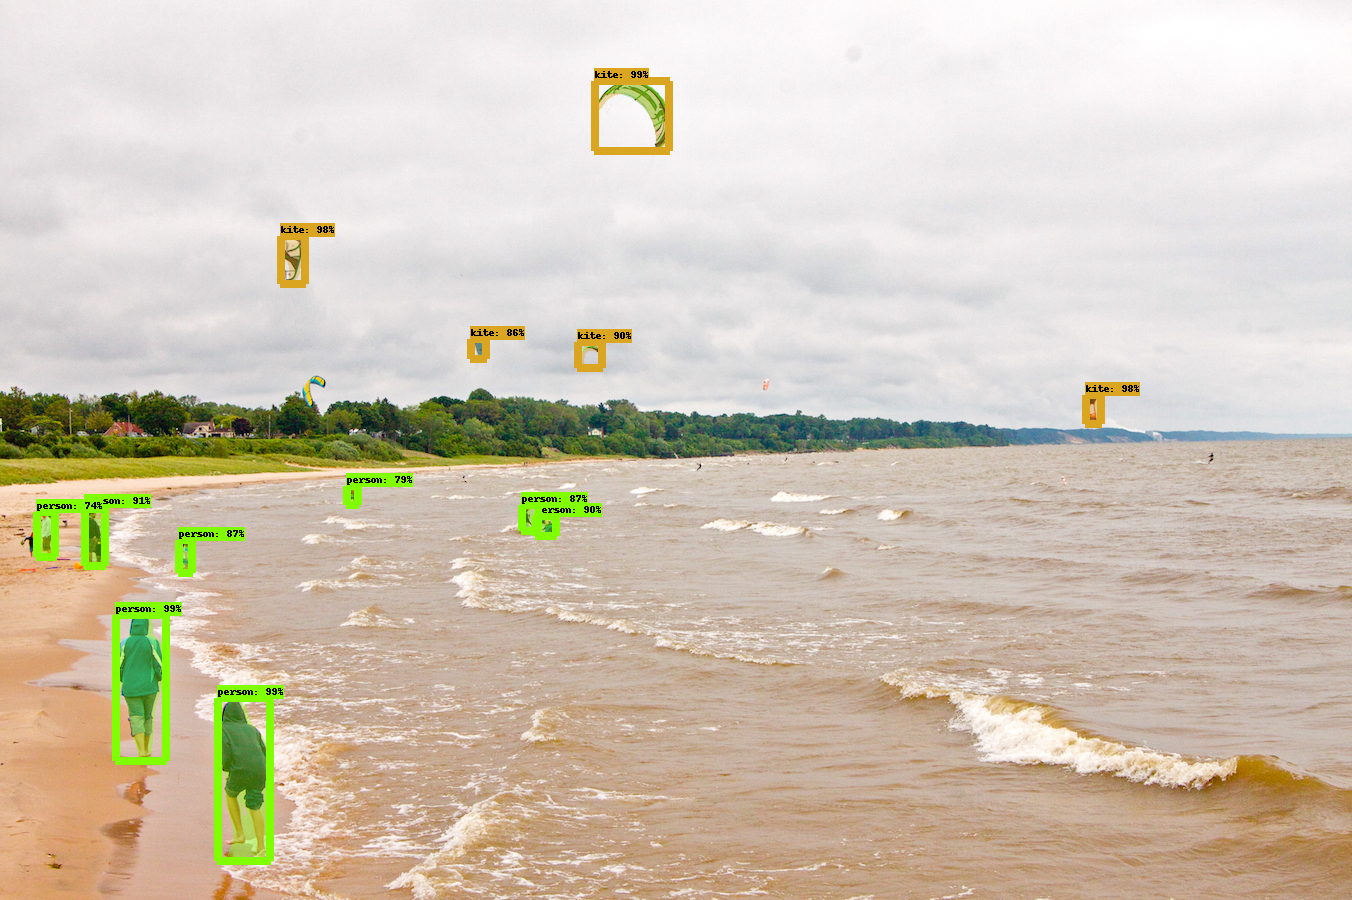

In [0]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(masking_model, image_path)

# CEO Foundry text_box fine tuning

The official pascal voc conversion script provided requires the examples and splits txt files as specified in the Pascal VOC 2012 dataset. We don't have those files from the converted annotation files. It is better to write a conversion script from dataturks format to the tf_record format required by the tensorflow Object Detection API.